In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, ChainDataset
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        sequence = [
            nn.Conv3d(1, 10, kernel_size=3, stride = 1, padding = 1),
            nn.MaxPool3d(2),
            nn.LeakyReLU(),
            nn.Conv3d(10, 20, kernel_size=3, stride = 1 , padding = 1),
            nn.MaxPool3d(2),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(2500, 250),
            nn.LeakyReLU(),
            nn.Linear(250, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1),
            nn.LeakyReLU()
        ]
        self.sequence = nn.Sequential(*sequence)

    def forward(self, x):
        return self.sequence(x)

In [4]:
realImages = np.load("originalSubsets.npy")
realImages.shape

(1967, 20, 20, 20)

In [5]:
fakeImages = np.load("rescaledSubsets.npy")
fakeImages.shape

(1967, 20, 20, 20)

In [6]:
import random
random.shuffle(realImages)
random.shuffle(fakeImages)

In [7]:
def addInfoToList(imageList, label, dataList):
    for image in imageList:
        dataList.append((image,label))

def getDataLoaderFromList(dataList):
    return DataLoader(dataList, shuffle=True)

In [8]:
trainData = []

trainDataSize = len(realImages) //2

addInfoToList(realImages[:trainDataSize], 0., trainData)

addInfoToList(fakeImages[:trainDataSize], 1., trainData)

print(len(trainData))

1966


In [9]:
validateData = []

validateDataSize = len(realImages) //4
validateDataSize +=trainDataSize
addInfoToList(realImages[trainDataSize: validateDataSize], 0., validateData)
addInfoToList(fakeImages[trainDataSize: validateDataSize], 1., validateData)

print(len(validateData))

982


In [10]:
testData = []

addInfoToList(realImages[validateDataSize:], 0., testData)
addInfoToList(fakeImages[validateDataSize:], 1., testData)
print(len(testData))

986


In [11]:
trainData = getDataLoaderFromList(trainData)

validateData = getDataLoaderFromList(validateData)

testData = getDataLoaderFromList(testData)

In [12]:
def getAccuracyFromModel(model, dataSet):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img,label in dataSet:
            img, label = img.unsqueeze(0).float().to(device), label.long().to(device)
            output = model(img)
            test_loss += modelLoss(output, label).item()
            #print(label, output)
            pred = output.view(-1)
            if label == 1 and pred >= .5:
                correct+=1
            elif label == 0 and pred < .5:
                correct +=1
        test_loss /= len(dataSet)
        test_losses.append(test_loss)
        model.train()
        return float(correct/len(dataSet))


In [13]:
learning_rate = 0.001
momentum = 0.5



In [14]:
model = Discriminator().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
modelLoss = torch.nn.MSELoss()

In [15]:
epochList = []

trainLossList = []
trainAccuracyList = []
validationAccuracyList = []


prevAccuracy = None

for epoch in range(1, 101):
    train_loss = 0
    for batch_idx, (img, target) in enumerate(trainData):
        img, target = img.unsqueeze(0).float().to(device), target.float().to(device)
        optimizer.zero_grad()
        output = model(img).view(-1)
        loss = modelLoss(output, target)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()
    validationAccuracy = getAccuracyFromModel(model, validateData) * 100.
    trainingAccuracy = getAccuracyFromModel(model, trainData) * 100.
    
    epochList.append(epoch)
    trainLossList.append(train_loss)    
    trainAccuracyList.append(trainingAccuracy)
    validationAccuracyList.append(validationAccuracy)
    
    print("Epoch # " + str(epoch) + " Accuracy = " + str(validationAccuracy))
    if prevAccuracy is None or validationAccuracy > prevAccuracy:
        prevAccuracy = validationAccuracy
        torch.save(model, 'bestModel.pkl')





/home/alex/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch # 1 Accuracy = 50.0
Epoch # 2 Accuracy = 50.0
Epoch # 3 Accuracy = 73.11608961303462
Epoch # 4 Accuracy = 60.28513238289206
Epoch # 5 Accuracy = 81.87372708757637
Epoch # 6 Accuracy = 80.95723014256619
Epoch # 7 Accuracy = 61.30346232179226
Epoch # 8 Accuracy = 75.35641547861506
Epoch # 9 Accuracy = 82.17922606924644
Epoch # 10 Accuracy = 69.85743380855396
Epoch # 11 Accuracy = 83.19755600814665
Epoch # 12 Accuracy = 84.62321792260693
Epoch # 13 Accuracy = 91.85336048879837
Epoch # 14 Accuracy = 90.020366598778
Epoch # 15 Accuracy = 91.85336048879837
Epoch # 16 Accuracy = 76.37474541751527
Epoch # 17 Accuracy = 80.04073319755601
Epoch # 18 Accuracy = 76.4765784114053
Epoch # 19 Accuracy = 91.0386965376782
Epoch # 20 Accuracy = 92.4643584521385
Epoch # 21 Accuracy = 91.85336048879837
Epoch # 22 Accuracy = 92.56619144602851
Epoch # 23 Accuracy = 72.81059063136456
Epoch # 24 Accuracy = 88.90020366598777
Epoch # 25 Accuracy = 79.0224032586558
Epoch # 26 Accuracy = 91.75152749490834
E

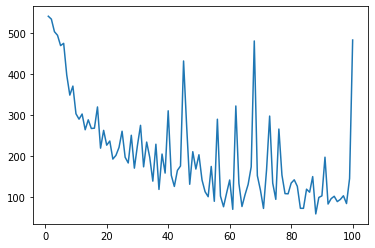

In [16]:
plt.plot(epochList, trainLossList)

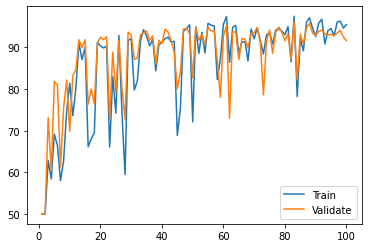

In [17]:
plt.plot(epochList, trainAccuracyList, label= "Train")
plt.plot(epochList, validationAccuracyList, label = "Validate")
plt.legend()
plt.show()

In [18]:
model = torch.load('bestModel.pkl')
accuracy = getAccuracyFromModel(model, testData) * 100.
print("Accuracy on testData " + str(accuracy))


Accuracy on testData 95.53752535496957
